# **ICE Champions league match result predictor**


Aquest Jupyter Notebook recull els resultats de la 1a temporada de la ICE Champions League. Al principi del codi es llegeixen les dades. Després, es calculen les estadísitques de cada participant d'acord amb els partits que ha jugat i els seus resultats. Seguidament, es mostren 4 classificacions d'exemple (Victòries/Partit, Gols/Partit, Gols d'equip / Partits atacant, Gols rebuts/Partits defensor). Es poden canviar els paràmetres per veure altres classificacions. Finalment, hi ha una versió preliminar d'un model de Deep Learning en el qual es predigui el resultat (Victòria o Derrota) per un partit donat.

Canvieu el que cregueu oportú!

In [1]:
#!pip install scikit-learn==1.0.2
#!pip install lime
#!pip install shap
#!pip install tqdm


### Importing Required Libraries

_We recommend you import all required libraries in one place (here):_

_It will take ~30 second to import the libraries._


In [2]:
import numpy as np
import pandas as pd
import random
from itertools import accumulate
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits, load_wine
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, classification_report

import lime
from lime import lime_tabular
# import shap

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Defining Helper Functions

_Use this section to define any helper functions to help the notebook's code readability:_


In [3]:
# This function will allow us to easily plot data taking in x values, y values, and a title
def plotter(matrix, normalized_matrix, title1, title2):
    fig, ax = plt.subplots(figsize=(16,8), ncols = 2, nrows = 1)
    im = ax[0].imshow(matrix, cmap = 'YlGn', aspect='equal')
    im_n = ax[1].imshow(normalized_matrix, cmap = 'YlGn', aspect='equal')
    
    # Valors de cada cel·la
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax[0].text(j, i, "{:.2f}".format(matrix.iloc[i, j]), ha='center', va='center', fontsize=7, color="black")
            ax[1].text(j, i, "{:.2f}".format(normalized_matrix.iloc[i, j]), ha='center', va='center', fontsize=7, color="black")
    
    # Add tick labels
    ax[0].set_title(title1)
    ax[1].set_title(title2)
    
    ax[0].set_xticks(ticks=np.arange(matrix.shape[1]))
    ax[0].set_xticklabels(matrix.columns, rotation=90, fontsize=8)
    ax[0].set_yticks(ticks=np.arange(matrix.shape[0]))
    ax[0].set_yticklabels(matrix.index, rotation=0, fontsize=8)
    ax[1].set_xticks(ticks=np.arange(normalized_matrix.shape[1]))
    ax[1].set_xticklabels(normalized_matrix.columns, rotation=90, fontsize=8)
    ax[1].set_yticks(ticks=np.arange(normalized_matrix.shape[0]))
    ax[1].set_yticklabels(normalized_matrix.index, rotation=0, fontsize=8)
   
    ax[0].set_ylabel("Team mate")
    ax[0].set_xlabel("Player")
    ax[1].set_ylabel("Team mate")
    ax[1].set_xlabel("Player")
    
    plt.show()

----


# Lectura de les dades

In [4]:
#!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0TUZEN/Training_games.csv'
Game_all = pd.read_csv('resultats.csv')
Game_all.head()

,Jugador 1,Jugador 2,Jugador 3,Jugador 4,Local,Visitant
0,Guille,Dani,Antía,Simone,3,2
1,Víctor,Nali,Pau,Rebeca,3,1
2,Alejandro,Guille,Dani,Luis,0,3
3,Víctor,Pau,Antía,Simone,3,2
4,Guille,Dani,Alejandro,Luis,3,1


In [5]:
Scored_all = pd.read_csv('gols.csv', index_col = 0).iloc[:,0] # llegim els gols com una pd.Series
Scored_all.head()

Nom jugador/a
Dani      256
Guille    121
Antía     125
Simone     43
Víctor    155
Name: Gols anotats, dtype: int64

Si cal, treiem els participants que han jugat menys. Com que hi ha poca mostra dels seus partits, afecten negativament al model.

In [6]:
remove_players = False
if remove_players:
    removing_players = ['Pablo', 'Oscar', 'Jordi', 'Maider', 'Julen', 'Andrés']
    # Identify rows to keep (rows without any value in the predefined list)
    mask_games = ~Game_all.isin(removing_players).any(axis=1)
    mask_scored = ~Scored_all.keys().isin(removing_players)
    
    # Filter the DataFrame
    Game_all = Game_all[mask_games]
    Scored_all = Scored_all[mask_scored]
    
    # Reset indices
    Game_all.reset_index(drop=True, inplace=True)

Llista de participants

In [7]:
Player_names = Scored_all.keys()
Player_names

Index(['Dani', 'Guille', 'Antía', 'Simone', 'Víctor', 'Pau', 'Alejandro',
       'Luis', 'Rebeca', 'Pedro', 'Nali', 'Pablo', 'Oscar', 'Jordi', 'Maider',
       'Andrés', 'Clàudia', 'Julen'],
      dtype='object', name='Nom jugador/a')

In [8]:
print("Nombre de participants: ", len(Player_names))

Nombre de participants:  18


# Estadístiques dels participants

Guardarem les dades dels participants en un únic dataframe. Aquests valors s'extreuen directament de `gols.csv` i de `resultats.csv`. Per altra banda, guardarem en un altre dataframe les estadístiques de cada participant, que es passaran directament al model.

In [9]:
Player_data = pd.DataFrame()
Player_stats = pd.DataFrame()

In [10]:
Player_data['Participant'] = Player_names # Columna amb el nom de cada participant
Player_stats['Participant'] = Player_names # Columna amb el nom de cada participant
Player_data['Gols'] = Player_data['Participant'].map(Scored_all) # columna amb els gols de cada participant

Nombre de partits jugats en total

In [11]:
list_participants_allgames = Game_all[['Jugador 1', 'Jugador 2', 'Jugador 3', 'Jugador 4']].values.flatten() # llista de tots els jugadors a cada partit
counts_played_all = pd.Series(list_participants_allgames).value_counts() # recompte de partits jugats per cada participant
Player_data['Partits jugats'] = Player_data['Participant'].map(counts_played_all) # columna amb els partits jugats, d'acord amb el nom del participant
Player_stats['Partits jugats'] = Player_data['Participant'].map(counts_played_all) # columna amb els partits jugats, d'acord amb el nom del participant

Nombre de partits jugats com a atacant i com a defensor

In [12]:
# Com a defensor (procediment igual que amb el recompte de partits totals)
list_participants_defender = Game_all[['Jugador 1', 'Jugador 3']].values.flatten()
counts_played_defender = pd.Series(list_participants_defender).value_counts()
Player_data['Partits defensor'] = Player_data['Participant'].map(counts_played_defender).fillna(0).astype(int) # fillna per substituir els NaN (no hi ha dades) per 0
Player_stats['Partits defensor / Partits jugats'] = Player_data['Partits defensor'].div(Player_data['Partits jugats'])

# Com a atacant (procediment igual que amb el recompte de partits totals)
list_participants_striker = Game_all[['Jugador 2', 'Jugador 4']].values.flatten()
counts_played_striker = pd.Series(list_participants_striker).value_counts()
Player_data['Partits atacant'] = Player_data['Participant'].map(counts_played_striker).fillna(0).astype(int) # fillna per substituir els NaN (no hi ha dades) per 0
Player_stats['Partits atacant / Partits jugats'] = Player_data['Partits atacant'].div(Player_data['Partits jugats'])

Nombre de partits jugats com a local i com a visitant

In [13]:
# Com a local (procediment igual que amb el recompte de partits totals)
list_participants_home = Game_all[['Jugador 1', 'Jugador 2']].values.flatten()
counts_played_home = pd.Series(list_participants_home).value_counts()
Player_data['Partits local'] = Player_data['Participant'].map(counts_played_home).fillna(0).astype(int) # fillna per substituir els NaN (no hi ha dades) per 0

# Com a visitant (procediment igual que amb el recompte de partits totals)
list_participants_away = Game_all[['Jugador 3', 'Jugador 4']].values.flatten()
counts_played_away = pd.Series(list_participants_away).value_counts()
Player_data['Partits visitant'] = Player_data['Participant'].map(counts_played_away).fillna(0).astype(int) # fillna per substituir els NaN (no hi ha dades) per 0

## Victòries i derrotes

Trobem quantes victòries ha tingut cada participant jugant com a local i jugant com a visitant. També anotem quants partits ha guanyat en total.

In [14]:
mask_local = Game_all['Local'] > Game_all['Visitant'] # partits on ha guanyat el local
mask_visitant = ~mask_local # partits on ha guanyat el visitant

# Com a local (procediment igual que amb el recompte de partits totals)
list_wins_local = Game_all[['Jugador 1', 'Jugador 2']][mask_local].values.flatten()
counts_wins_local = pd.Series(list_wins_local).value_counts()
Player_data['Partits guanyats local'] = Player_data['Participant'].map(counts_wins_local).fillna(0).astype(int) # fillna per substituir els NaN (no hi ha dades) per 0

# Com a visitant
list_wins_visitant = Game_all[['Jugador 3', 'Jugador 4']][mask_visitant].values.flatten()
counts_wins_visitant = pd.Series(list_wins_visitant).value_counts()
Player_data['Partits guanyats visitant'] = Player_data['Participant'].map(counts_wins_visitant).fillna(0).astype(int) # fillna per substituir els NaN (no hi ha dades) per 0

# Victòries en total
counts_wins_all = counts_wins_local + counts_wins_visitant
Player_data['Partits guanyats total'] = Player_data['Participant'].map(counts_wins_all).fillna(0).astype(int) # fillna per substituir els NaN (no hi ha dades) per 0
Player_stats['Partits guanyats total'] = Player_data['Participant'].map(counts_wins_all).fillna(0).astype(int) # fillna per substituir els NaN (no hi ha dades) per 0

#Partits guanyats per partit jugat
Player_stats['Partits guanyats total / Partits jugats'] = Player_stats['Partits guanyats total'] / Player_stats['Partits jugats']

Trobem quants partits ha guanyat cada participant jugant com a atacant i quants ha guanyat jugant com a defensor.

In [15]:
# Com a defensor (procediment igual que amb el recompte de partits totals)
list_wins_defender_local = Game_all['Jugador 1'][mask_local].values.flatten() # llista de guanyadors defensors locals
list_wins_defender_visitant = Game_all['Jugador 3'][mask_visitant].values.flatten() # llista de guanyadors defensors visitants
counts_wins_defender_local = pd.Series(list_wins_defender_local).value_counts() # recompte de victòries com a defensor local
counts_wins_defender_visitant = pd.Series(list_wins_defender_visitant).value_counts() #recompte de victòries com a defensor local

# Afegim a la llista els participants que no han guanyat cap partit en aquesta posició
no_winners_defender_local = [0 for player in Player_data['Participant'] if player not in counts_wins_defender_local.keys()]
no_winners_defender_local_names = [player for player in Player_data['Participant'] if player not in counts_wins_defender_local.keys()]
series_no_winners_defender_local = pd.Series(no_winners_defender_local, index = no_winners_defender_local_names)
counts_wins_defender_local = counts_wins_defender_local.add(series_no_winners_defender_local, fill_value = 0).astype(int)

no_winners_defender_visitant = [0 for player in Player_data['Participant'] if player not in counts_wins_defender_visitant.keys()]
no_winners_defender_visitant_names = [player for player in Player_data['Participant'] if player not in counts_wins_defender_visitant.keys()]
series_no_winners_defender_visitant = pd.Series(no_winners_defender_visitant, index = no_winners_defender_visitant_names)
counts_wins_defender_visitant = counts_wins_defender_visitant.add(series_no_winners_defender_visitant, fill_value = 0).astype(int)

counts_wins_defender_total = counts_wins_defender_visitant + counts_wins_defender_local # recompte de victòries com a defensor

# Guardem resultats al dataframe
Player_data['Partits guanyats defensor total'] = Player_data['Participant'].map(counts_wins_defender_total).fillna(0).astype(int) # fillna per substituir els NaN (no hi ha dades) per 0
Player_data['Partits guanyats defensor local'] = Player_data['Participant'].map(counts_wins_defender_local).fillna(0).astype(int)
Player_data['Partits guanyats defensor visitant'] = Player_data['Participant'].map(counts_wins_defender_visitant).fillna(0).astype(int)

In [16]:
# Com a atacant (procediment igual que amb el recompte de partits totals)
list_wins_striker_local = Game_all['Jugador 2'][mask_local].values.flatten() # llista de guanyadors atacants locals
list_wins_striker_visitant = Game_all['Jugador 4'][mask_visitant].values.flatten() # llista de guanyadors atacants visitants
counts_wins_striker_local = pd.Series(list_wins_striker_local).value_counts() # recompte de victòries com a atacant local
counts_wins_striker_visitant = pd.Series(list_wins_striker_visitant).value_counts() #recompte de victòries com a atacant local

# Afegim a la llista els participants que no han guanyat cap partit en aquesta posició
no_winners_striker_local = [0 for player in Player_data['Participant'] if player not in counts_wins_striker_local.keys()]
no_winners_striker_local_names = [player for player in Player_data['Participant'] if player not in counts_wins_striker_local.keys()]
series_no_winners_striker_local = pd.Series(no_winners_striker_local, index = no_winners_striker_local_names)
counts_wins_striker_local = counts_wins_striker_local.add(series_no_winners_striker_local, fill_value = 0).astype(int)

no_winners_striker_visitant = [0 for player in Player_data['Participant'] if player not in counts_wins_striker_visitant.keys()]
no_winners_striker_visitant_names = [player for player in Player_data['Participant'] if player not in counts_wins_striker_visitant.keys()]
series_no_winners_striker_visitant = pd.Series(no_winners_striker_visitant, index = no_winners_striker_visitant_names)
counts_wins_striker_visitant = counts_wins_striker_visitant.add(series_no_winners_striker_visitant, fill_value = 0).astype(int)

counts_wins_striker_total = counts_wins_striker_visitant + counts_wins_striker_local # recompte de victòries com a atacant

# Guardem resultats al dataframe
Player_data['Partits guanyats atacant total'] = Player_data['Participant'].map(counts_wins_striker_total).fillna(0).astype(int) # fillna per substituir els NaN (no hi ha dades) per 0
Player_data['Partits guanyats atacant local'] = Player_data['Participant'].map(counts_wins_striker_local).fillna(0).astype(int)
Player_data['Partits guanyats atacant visitant'] = Player_data['Participant'].map(counts_wins_striker_visitant).fillna(0).astype(int)

Comprovem que hem fet els càlculs bé. La suma de columnes desglossades (victòries local + victòries visitant) ha de ser igual a les columnes total (victòries totals). El número d'output de qualsevol de les línies següents ha de ser igual al nombre de participants.

In [17]:
#((Player_data['Partits guanyats defensor total'] + Player_data['Partits guanyats atacant total']) == Player_data['Partits guanyats total']).sum()
#((Player_data['Partits guanyats defensor local'] + Player_data['Partits guanyats defensor visitant']) == Player_data['Partits guanyats defensor total']).sum()
#((Player_data['Partits guanyats atacant local'] + Player_data['Partits guanyats atacant visitant']) == Player_data['Partits guanyats atacant total']).sum()

### Gols

A partir dels gols que ha marcat en total cada participant, calculem les mitjanes de gols per partit i a cada posició.

In [18]:
Player_stats['Gols anotats / Partit'] = Player_data['Gols'] / Player_data['Partits jugats']

A continuació guardarem una sèrie de valors estadístics per cada jugador, que ens indiquen la seva capacitat ofensiva i defensiva:
- Gols anotats defensor / Partits defensor: capacitat ofensiva jugant com a defensor
- Gols anotats atacant / Partits acatant: capacitat ofensiva jugant com a atacant
- Gols rebuts defensor / Partits defensor: capacitat defensiva jugant com a defensor
- Gols rebuts atacant / Partits atacant: capacitat defensiva jugant com a atacant
- 
Aquests paràmetres caracteritzen cada participant i es guarden a `Player_stats`.

In [19]:
## Gols rebuts com a defensor
# Llistes on hi guardem els resultats per cada jugador
Goals_received_home = [] # gols rebuts jugant com a defensor local
Goals_received_away = [] # gols rebuts jugant com a defensor visitant
Goals_received_defender = [] # gols totals rebuts jugant com a defensor
Goals_received_home_norm = [] # igual que a dalt, però normalitzat respecte els partits jugats en aquella posició
Goals_received_away_norm = []
Goals_received_defender_norm = []
Goals_scored_home = [] # gols anotats jugant com a defensor local
Goals_scored_away = [] # gols anotats jugant com a defensor visitant
Goals_scored_defender = [] # gols totals anotats jugant com a defensor
Goals_scored_home_norm = [] # igual que a dalt, però normalitzat respecte els partits jugats en aquella posició
Goals_scored_away_norm = []
Goals_scored_defender_norm = []

for player in Player_data['Participant']:
    Games_defender_home = Game_all[(Game_all['Jugador 1'] == player)] #partits on el participant ha jugat com a defensor local
    Games_defender_away = Game_all[(Game_all['Jugador 3'] == player)] # partits on el participant ha jugat com a defensor visitant

    number_games_home = Games_defender_home.shape[0] # nombre de partits jugats com a defensor local
    number_games_away = Games_defender_away.shape[0]
    
    received_goals_home = Games_defender_home['Visitant'].sum() # gols rebuts jugant com a defensor local
    received_goals_away = Games_defender_away['Local'].sum() # gols rebuts jugant com a defensor visitant
    scored_goals_home = Games_defender_home['Local'].sum() # gols anotats jugant com a defensor local
    scored_goals_away = Games_defender_away['Visitant'].sum() # gols anotats jugant com a defensor visitant
    

    # Guardem els resultats a les arrays corresponents
    Goals_received_home.append(received_goals_home)
    Goals_received_away.append(received_goals_away)
    Goals_received_defender.append(received_goals_home + received_goals_away)
    Goals_received_home_norm.append(received_goals_home / number_games_home)
    Goals_received_away_norm.append(received_goals_away / number_games_away)
    Goals_scored_home.append(scored_goals_home)
    Goals_scored_away.append(scored_goals_away)
    Goals_scored_defender.append(received_goals_home + received_goals_away)
    Goals_scored_home_norm.append(scored_goals_home / number_games_home)
    Goals_scored_away_norm.append(scored_goals_away / number_games_away)
    
    Goals_received_defender_norm.append((received_goals_home + received_goals_away) / (number_games_home + number_games_away))
    Goals_scored_defender_norm.append((scored_goals_home + scored_goals_away) / (number_games_home + number_games_away))

# Guardem els resultats per tots els jugadors en noves columnes
Player_data['Gols rebuts defensor local'] = Goals_received_home
Player_data['Gols rebuts defensor visitant'] = Goals_received_away
Player_data['Gols rebuts defensor'] = Goals_received_defender
Player_data['Gols anotats defensor local'] = Goals_scored_home
Player_data['Gols anotats defensor visitant'] = Goals_scored_away
Player_data['Gols anotats defensor'] = Goals_scored_defender

#Estadística de participant
Player_stats['Gols anotats defensor local / Partits defensor local'] = Goals_scored_home_norm
Player_stats['Gols anotats defensor visitant / Partits defensor visitant'] = Goals_scored_away_norm
Player_stats['Gols rebuts defensor / Partits defensor'] = Goals_received_defender_norm
Player_stats['Gols anotats defensor / Partits defensor'] = Goals_scored_defender_norm
Player_stats['Gols rebuts defensor local / Partits defensor local'] = Goals_received_home_norm
Player_stats['Gols rebuts defensor visitant / Partits defensor visitant'] = Goals_received_away_norm

In [20]:
## Estadística com a atacant
## Gols rebuts com a atacant
# Llistes on hi guardem els resultats per cada jugador
Goals_received_home = [] # gols rebuts jugant com a atacant local
Goals_received_away = [] # gols rebuts jugant com a atacant visitant
Goals_received_striker = [] # gols totals rebuts jugant com a atacant
Goals_received_home_norm = [] # igual que a dalt, però normalitzat respecte els partits jugats en aquella posició
Goals_received_away_norm = []
Goals_received_striker_norm = []
Goals_scored_home = [] # gols anotats jugant com a atacant local
Goals_scored_away = [] # gols anotats jugant com a atacant visitant
Goals_scored_striker = [] # gols totals anotats jugant com a atacant
Goals_scored_home_norm = [] # igual que a dalt, però normalitzat respecte els partits jugats en aquella posició
Goals_scored_away_norm = []
Goals_scored_striker_norm = []

for player in Player_data['Participant']:
    Games_striker_home = Game_all[(Game_all['Jugador 2'] == player)] #partits on el participant ha jugat com a atacant local
    Games_striker_away = Game_all[(Game_all['Jugador 4'] == player)] # partits on el participant ha jugat com a atacant visitant

    number_games_home = Games_striker_home.shape[0] # nombre de partits jugats com a atacant local
    number_games_away = Games_striker_away.shape[0]
    
    received_goals_home = Games_striker_home['Visitant'].sum() # gols rebuts jugant com a atacant local
    received_goals_away = Games_striker_away['Local'].sum() # gols rebuts jugant com a atacant visitant
    scored_goals_home = Games_striker_home['Local'].sum() # gols anotats jugant com a atacant local
    scored_goals_away = Games_striker_away['Visitant'].sum() # gols anotats jugant com a atacant visitant
    
    # Guardem els resultats a les arrays corresponents
    Goals_received_home.append(received_goals_home)
    Goals_received_away.append(received_goals_away)
    Goals_received_striker.append(received_goals_home + received_goals_away)
    Goals_received_home_norm.append(received_goals_home / number_games_home)
    Goals_received_away_norm.append(received_goals_away / number_games_away)
    Goals_scored_home.append(scored_goals_home)
    Goals_scored_away.append(scored_goals_away)
    Goals_scored_striker.append(received_goals_home + received_goals_away)
    Goals_scored_home_norm.append(scored_goals_home / number_games_home)
    Goals_scored_away_norm.append(scored_goals_away / number_games_away)
    
    Goals_received_striker_norm.append((received_goals_home + received_goals_away) / (number_games_home + number_games_away))
    Goals_scored_striker_norm.append((scored_goals_home + scored_goals_away) / (number_games_home + number_games_away))

# Guardem els resultats per tots els jugadors en noves columnes
Player_data['Gols rebuts atacant local'] = Goals_received_home
Player_data['Gols rebuts atacant visitant'] = Goals_received_away
Player_data['Gols rebuts atacant'] = Goals_received_striker
Player_data['Gols anotats atacant local'] = Goals_scored_home
Player_data['Gols anotats atacant visitant'] = Goals_scored_away
Player_data['Gols anotats atacant'] = Goals_scored_striker

# Estadística de participant
Player_stats['Gols anotats atacant local / Partits atacant local'] = Goals_scored_home_norm
Player_stats['Gols anotats atacant visitant / Partits atacant visitant'] = Goals_scored_away_norm
Player_stats['Gols rebuts atacant / Partits atacant'] = Goals_received_striker_norm
Player_stats['Gols anotats atacant / Partits atacant'] = Goals_scored_striker_norm
Player_stats['Gols rebuts atacant local / Partits atacant local'] = Goals_received_home_norm
Player_stats['Gols rebuts atacant visitant / Partits atacant visitant'] = Goals_received_away_norm

In [21]:
Player_stats.head()

,Participant,Partits jugats,Partits defensor / Partits jugats,Partits atacant / Partits jugats,Partits guanyats total,Partits guanyats total / Partits jugats,Gols anotats / Partit,Gols anotats defensor local / Partits defensor local,Gols anotats defensor visitant / Partits defensor visitant,Gols rebuts defensor / Partits defensor,Gols anotats defensor / Partits defensor,Gols rebuts defensor local / Partits defensor local,Gols rebuts defensor visitant / Partits defensor visitant,Gols anotats atacant local / Partits atacant local,Gols anotats atacant visitant / Partits atacant visitant,Gols rebuts atacant / Partits atacant,Gols anotats atacant / Partits atacant,Gols rebuts atacant local / Partits atacant local,Gols rebuts atacant visitant / Partits atacant visitant
0,Dani,177,0.259887,0.740113,111,0.627119,1.446328,2.120000,2.285714,1.760870,2.195652,1.800000,1.714286,2.430769,2.424242,1.786260,2.427481,1.815385,1.757576
1,Guille,164,0.774390,0.225610,66,0.402439,0.737805,1.848485,1.934426,2.236220,1.889764,2.272727,2.196721,1.181818,2.076923,2.243243,1.810811,2.636364,2.076923
2,Antía,173,0.763006,0.236994,87,0.502890,0.722543,2.044118,2.156250,2.015152,2.098485,2.029412,2.000000,1.923077,1.733333,2.073171,1.853659,1.884615,2.400000
3,Simone,39,0.256410,0.743590,21,0.538462,1.102564,2.000000,1.500000,2.000000,1.800000,1.833333,2.250000,2.375000,1.923077,2.034483,2.172414,1.875000,2.230769
4,Víctor,107,0.514019,0.485981,79,0.738318,1.448598,2.111111,2.891892,1.400000,2.636364,2.000000,1.108108,2.400000,2.407407,1.807692,2.403846,1.760000,1.851852


### Freqüència de parelles

A continuació es calcularà quantes vegades s'ha repetit cada parella. El mapa de calor resultant ens pot servir per veure quines parelles estan sobrerepresentades.

In [22]:
Teams_freqs = pd.DataFrame() # dataframe on hi guardem les freqüències
Teams_freqs_norm = pd.DataFrame() # dataframe on hi guardem les freqüències normalitzades per partits jugats

# Possibles combinacions, on la primera posició és el participant en qüestió i la segona posició és el company
lineup_combinations = [['Jugador 1', 'Jugador 2'], ['Jugador 2', 'Jugador 1'], ['Jugador 3', 'Jugador 4'], ['Jugador 4', 'Jugador 3']]

for player in Player_data['Participant']:
    for position in lineup_combinations: # per a cada alineació
        Games_position = Game_all[Game_all[position[0]] == player] # partits que ha jugat a la posició (e.g. atacant)
        mates_position = Games_position[position[1]].value_counts() # recompte de company que ha tingut jugant com a posició complementària (eg defensa)
    
        # afegim els companys que no ha tingut jugant en aquesta posició, tots amb un recompte igual a 0
        no_mates_position = [0 for player in Player_data['Participant'] if player not in mates_position.keys()] # valors 0
        no_mates_position_names = [player for player in Player_data['Participant'] if player not in mates_position.keys()] #noms 
        series_no_mates_position = pd.Series(no_mates_position, index = no_mates_position_names) # ho ajuntem en una pd.Series
        mates_position = mates_position.add(series_no_mates_position, fill_value = 0).astype(int) # afegim al recompte d'abans
 
        if position == lineup_combinations[0]:
            Teammates_counter = mates_position # sèrie on hi guardarem el nombre de vegades que player ha jugat amb cada altre participant
        else:
            Teammates_counter += mates_position # afegim el recompte (ho podem sumar així perquè cada valor de mates_position té un índex corresponent a l'altre participant

    Teams_freqs[player] = Teammates_counter.astype(int) # guardem la freqüència de parelles per aquest participant
    Teams_freqs_norm[player] = Teammates_counter.astype(int) / Teammates_counter.sum() # guardem la freqüència de parelles normalitzada

Teams_freqs = Teams_freqs.reindex(Player_data['Participant']) # ordenem per índex de participant
Teams_freqs_norm = Teams_freqs_norm.reindex(Player_data['Participant']) # ordenem per índex de participant
#Teams_freqs.head()

A continuació calculem el percentatge victòries de cada parella que ha jugat.

In [23]:
Teams_wins = pd.DataFrame() # dataframe on hi guardem les victòries

# Possibles combinacions, on la primera posició és el participant en qüestió i la segona posició és el company
lineup_combinations = [['Jugador 1', 'Jugador 2'], ['Jugador 2', 'Jugador 1'], ['Jugador 3', 'Jugador 4'], ['Jugador 4', 'Jugador 3']]

for player in Player_data['Participant']:
    for position in lineup_combinations: # per a cada alineació
        Games_position = Game_all[Game_all[position[0]] == player] # partits que ha jugat a la posició (e.g. atacant)
        if lineup_combinations in lineup_combinations[:2]:
            winning_games_mask = Games_position['Local'] > Games_position['Visitant']
        else:
            winning_games_mask = Games_position['Visitant'] > Games_position['Local']
        Games_position_wins = Games_position[winning_games_mask] # partits on ha jugat a la posició i ha guanyat
        mates_position = Games_position_wins[position[1]].value_counts() # recompte de company amb qui ha guanyat que ha tingut jugant com a posició complementària (eg defensa)
        
        # afegim els companys que no ha tingut jugant en aquesta posició al recompte, tots amb un recompte igual a 0
        no_mates_position = [0 for player in Player_data['Participant'] if player not in mates_position.keys()] # valors 0
        no_mates_position_names = [player for player in Player_data['Participant'] if player not in mates_position.keys()] #noms 
        series_no_mates_position = pd.Series(no_mates_position, index = no_mates_position_names) # ho ajuntem en una pd.Series
        mates_position = mates_position.add(series_no_mates_position, fill_value = 0).astype(int) # afegim al recompte anterior
        
        if position == lineup_combinations[0]:
            Teammates_counter = mates_position # sèrie on hi guardarem el nombre de vegades que player ha guanyat amb cada altre participant
        else:
            Teammates_counter += mates_position # afegim el recompte (ho podem sumar així perquè cada valor de mates_position té un índex corresponent a l'altre participant
   
    Teams_wins[player] = Teammates_counter.astype(int) # guardem la freqüència de parelles per aquest participant

Teams_wins = Teams_wins.reindex(Player_data['Participant']) # ordenem per índex de participant
Teams_wins_norm = Teams_wins / Teams_freqs # victòries normalitzades per les vegades que ha jugat aquella parella

# Resultats i classificacions

A continuació pintem la matriu que indica quants partits ha jugat cada jugador amb cada possible parella. Aquesta és una matriu simètrica amb 0 a la diagonal. També pintem la mateixa matriu normalitzada pel nombre de partits jugats. Aquesta matriu ja no és simètrica perquè no tothom ha jugat els mateixos partits. Està normalitzat respecte el nombre de partits que ha jugat el participant a l'eix x.

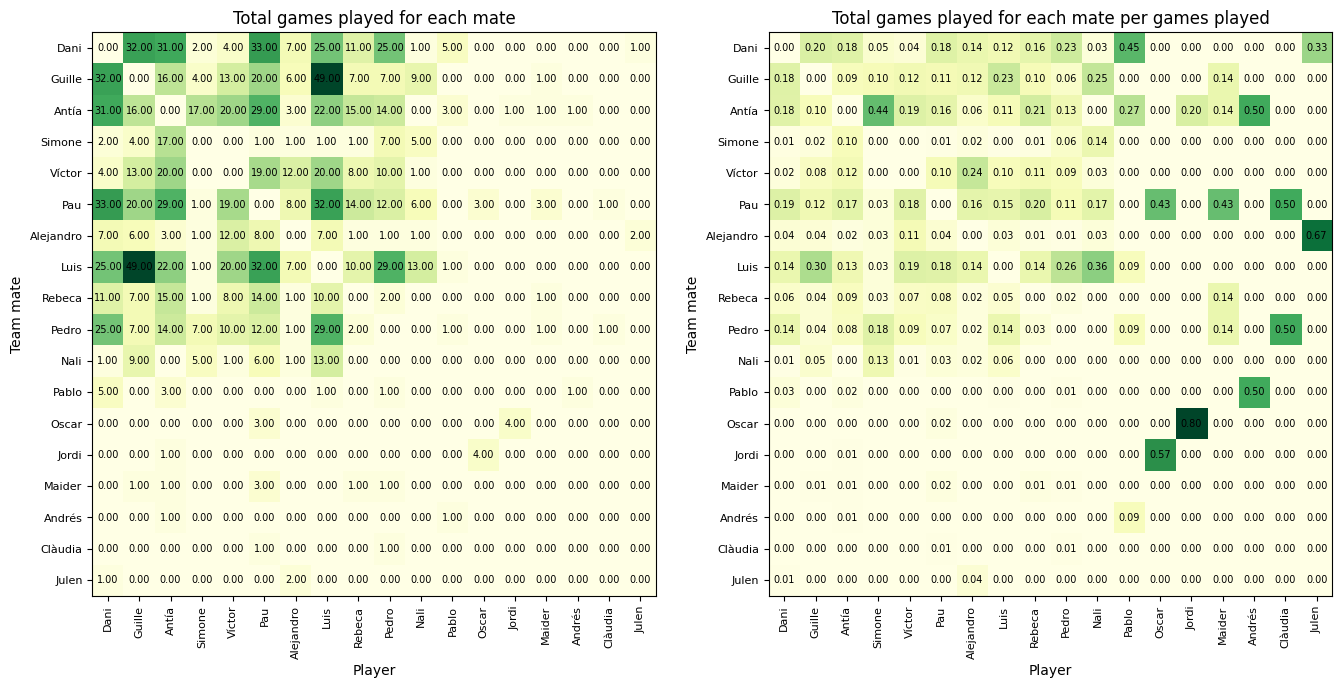

In [24]:
plotter(Teams_freqs, Teams_freqs_norm, "Total games played for each mate", "Total games played for each mate per games played")

## Rendiment de parelles

En aquesta secció mirarem quines són les parelles que més han rendit (i les que menys).

Pintem els resultats. Els colors vermells indiquen que la parella té més derrotes que victòries i els verds indiquen el contrari. Els valors `nan` indiquen que aquesta parella no ha jugat cap partit.

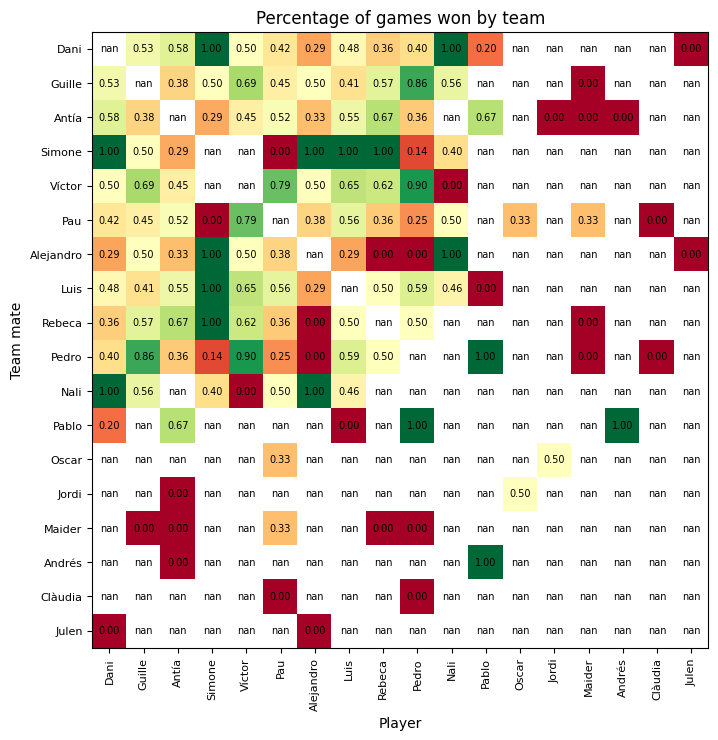

In [25]:
plt.figure(figsize=(8,8))
im = plt.imshow(Teams_wins_norm, cmap = 'RdYlGn', vmin = 0, vmax = 1, aspect='equal')

# Valors de cada cel·la
for i in range(Teams_wins.shape[0]):
    for j in range(Teams_wins.shape[1]):
        plt.text(j, i, "{:.2f}".format(Teams_wins_norm.iloc[i, j]), ha='center', va='center', fontsize=7, color="black")

# Add tick labels
plt.title("Percentage of games won by team")
plt.xticks(ticks=np.arange(Teams_wins_norm.shape[1]), labels=Teams_wins_norm.columns, rotation=90, fontsize=8)
plt.yticks(ticks=np.arange(Teams_wins_norm.shape[0]), labels=Teams_wins_norm.index, fontsize=8)
plt.ylabel("Team mate")
plt.xlabel("Player")
plt.show()

In [26]:
best_team = Teams_wins_norm[Teams_freqs > 3].stack().idxmax()
worst_team = Teams_wins_norm[Teams_freqs > 3].stack().idxmin()
print(f"Best team is: {best_team[0]} and {best_team[1]}")
print(f"Worst team is: {worst_team[0]} and {worst_team[1]}")
print("(estimated with at least 3 games played by the team)")

Best team is: Víctor and Pedro
Worst team is: Simone and Pedro
(estimated with at least 3 games played by the team)


## Classificacions finals

A continuació mostrem les classificacions dels jugadors a nivell individual.

### Victòries / Partit

Aquest paràmetre indica quin percentatge de victòries té cada jugador tenint en compte tots els partits que ha jugat en totes les posicions.

In [27]:
sorted_df = Player_stats.sort_values('Partits guanyats total / Partits jugats', ascending = False)
sorted_df[['Participant', 'Partits guanyats total / Partits jugats']]

,Participant,Partits guanyats total / Partits jugats
4,Víctor,0.738318
0,Dani,0.627119
5,Pau,0.613260
3,Simone,0.538462
2,Antía,0.502890
9,Pedro,0.500000
6,Alejandro,0.448980
12,Oscar,0.428571
1,Guille,0.402439
13,Jordi,0.400000


### Gols / Partit

Classificació Pichichi.

In [28]:
sorted_df = Player_stats.sort_values('Gols anotats / Partit', ascending = False)
sorted_df[['Participant', 'Gols anotats / Partit']]

,Participant,Gols anotats / Partit
5,Pau,1.486188
4,Víctor,1.448598
0,Dani,1.446328
3,Simone,1.102564
13,Jordi,1.000000
9,Pedro,0.836364
7,Luis,0.832536
6,Alejandro,0.755102
1,Guille,0.737805
11,Pablo,0.727273


### Gols rebuts / Partits defensor

Aquest paràmetre indica la capacitat defensiva de cada jugador. Com més proper a 0, vol dir que als partits li solen marcar menys gols.

In [29]:
sorted_df = Player_stats.sort_values('Gols rebuts defensor / Partits defensor', ascending = True)
sorted_df[['Participant', 'Gols rebuts defensor / Partits defensor']]

,Participant,Gols rebuts defensor / Partits defensor
4,Víctor,1.400000
0,Dani,1.760870
11,Pablo,1.833333
5,Pau,1.907407
3,Simone,2.000000
14,Maider,2.000000
2,Antía,2.015152
6,Alejandro,2.068182
9,Pedro,2.126214
1,Guille,2.236220


### Gols atacant / Partits atacant 

A diferència de l'anterior, els gols atacant indica quants gols ha marcat l'equip estant el jugador en posició atacant, però podria ser que qui ha marcat els gols fos el defensor de l'equip. Aquest paràmetre indica la capacitat ofensiva del participant per l'equip.

In [30]:
sorted_df = Player_stats.sort_values('Gols anotats atacant / Partits atacant', ascending = False)
sorted_df[['Participant', 'Gols anotats atacant / Partits atacant']]

,Participant,Gols anotats atacant / Partits atacant
0,Dani,2.427481
4,Víctor,2.403846
5,Pau,2.377953
9,Pedro,2.285714
3,Simone,2.172414
15,Andrés,2.000000
2,Antía,1.853659
7,Luis,1.842424
1,Guille,1.810811
11,Pablo,1.800000


# Model deep learning

El model de deep learning tindrà en compte els següents paràmetres estadístics recopilats a `Player_stats`. Primer cal construir el model i després en farem les prediccions.

### Preparació de les dades dels resultats

Aprofitem les alineacions i resultats dels partits dels quals hem anotat el resultat. Anomenarem cada participant amb un índex, enlloc del seu nom, que ens permetrà accedir a les seves estadístiques.

Creem un diccionari que assigna a cada jugador un número (índex de jugador).

In [31]:
players_indices = {}
for i in range(len(Player_data['Participant'])):
    players_indices[Player_data['Participant'].iloc[i]] = i

Reescrivim el DataFrame amb el registre de partits amb l'índex de jugador

In [32]:
Game_model = Game_all.copy()
Game_model = Game_model.replace(players_indices)
Game_model.head()

,Jugador 1,Jugador 2,Jugador 3,Jugador 4,Local,Visitant
0,1,0,2,3,3,2
1,4,10,5,8,3,1
2,6,1,0,7,0,3
3,4,5,2,3,3,2
4,1,0,6,7,3,1


In [33]:
#show the first player in the first of the training games
Player_stats.loc[(Game_model.loc[0]['Jugador 1'])]

Participant                                                     Guille
Partits jugats                                                     164
Partits defensor / Partits jugats                              0.77439
Partits atacant / Partits jugats                               0.22561
Partits guanyats total                                              66
Partits guanyats total / Partits jugats                       0.402439
Gols anotats / Partit                                         0.737805
Gols anotats defensor local / Partits defensor local          1.848485
Gols anotats defensor visitant / Partits defensor visitant    1.934426
Gols rebuts defensor / Partits defensor                        2.23622
Gols anotats defensor / Partits defensor                      1.889764
Gols rebuts defensor local / Partits defensor local           2.272727
Gols rebuts defensor visitant / Partits defensor visitant     2.196721
Gols anotats atacant local / Partits atacant local            1.181818
Gols a

#### Preparació dels paràmetres dels jugadors

Per cada partit de l'entrenament del model, ens cal assignar les propietats de cada jugador que hi participava.

Crearem diferents dataframes i finalment els agruparem tots en un de sol, que serà el que inclourà els paràmetres dels nostres jugadors. Podem crear tants dataframes com volguem. Cada dataframe inclourà un conjunt de paràmetres dels jugadors. (crec que es podria aprofitar `Player_stats`i comprimir totes aquestes línies)

In [34]:
# Gols anotats / Partit (en global)
team_scoredgoalsmatch = []
print(Game_model)
print(Game_model.shape)
for i in range(Game_model.shape[0]):
    # Índexs del quatre jugadors al camp
    team_index = list(Game_model.loc[i][:4])
    print(team_index)
    
    # Treiem la valoració de cada jugador per aquest paràmetre
    temp = Player_stats.iloc[team_index]['Gols anotats / Partit']
    team_scoredgoalsmatch.append(list(temp))

# Create the DataFrame for the player overall    
cols = []
for i in range(4):
    cols.append('Player'+str(i+1)+'_Scoredgoals_match') 

Train_df_goals = pd.DataFrame(team_scoredgoalsmatch, columns=cols)
Train_df_goals.head()

     Jugador 1  Jugador 2  Jugador 3  Jugador 4  Local  Visitant
0            1          0          2          3      3         2
1            4         10          5          8      3         1
2            6          1          0          7      0         3
3            4          5          2          3      3         2
4            1          0          6          7      3         1
..         ...        ...        ...        ...    ...       ...
333          1          7          8          2      1         3
334          1          7          8          2      3         2
335          2          1          7          8      3         1
336          2          1          7          8      3         1
337          8          1          2          7      1         3

[338 rows x 6 columns]
(338, 6)
[1, 0, 2, 3]
[4, 10, 5, 8]
[6, 1, 0, 7]
[4, 5, 2, 3]
[1, 0, 6, 7]
[9, 3, 0, 4]
[9, 3, 7, 2]
[9, 3, 5, 10]
[2, 4, 8, 0]
[2, 4, 5, 7]
[5, 4, 0, 8]
[5, 3, 7, 10]
[5, 4, 9, 0]
[6, 10, 9, 0]
[

,Player1_Scoredgoals_match,Player2_Scoredgoals_match,Player3_Scoredgoals_match,Player4_Scoredgoals_match
0,0.737805,1.446328,0.722543,1.102564
1,1.448598,0.277778,1.486188,0.542857
2,0.755102,0.737805,1.446328,0.832536
3,1.448598,1.486188,0.722543,1.102564
4,0.737805,1.446328,0.755102,0.832536


In [35]:
# Gols anotats / Partit (tenint en compte la posició on juga el participant)
team_scoredgoalsmatch_position = []
for i in range(Game_model.shape[0]):
    # Índexs del quatre jugadors al camp
    team_index = list(Game_model.loc[i][:4])
    strikers_index = list([team_index[1], team_index[3]])
    defenders_index = list([team_index[0], team_index[2]])
    
    # Treiem la valoració de cada jugador per posició
    temp_strik_home = Player_stats.iloc[team_index[1]]['Gols anotats atacant local / Partits atacant local']
    temp_defen_home = Player_stats.iloc[team_index[0]]['Gols anotats defensor local / Partits defensor local']
    temp_strik_away = Player_stats.iloc[team_index[3]]['Gols anotats atacant visitant / Partits atacant visitant']
    temp_defen_away = Player_stats.iloc[team_index[2]]['Gols anotats defensor visitant / Partits defensor visitant']
    temp = [temp_defen_home, temp_strik_home, temp_defen_away, temp_strik_away]
    
    team_scoredgoalsmatch_position.append(list(temp))

# Create the DataFrame for the player overall    
cols = []
for i in range(4):
    cols.append('Player'+str(i+1)+'_Scoredgoals_match_position') 
Train_df_goalsposition = pd.DataFrame(team_scoredgoalsmatch_position, columns=cols)
Train_df_goalsposition.head()

,Player1_Scoredgoals_match_position,Player2_Scoredgoals_match_position,Player3_Scoredgoals_match_position,Player4_Scoredgoals_match_position
0,1.848485,2.430769,2.156250,1.923077
1,2.111111,1.250000,2.290323,1.714286
2,2.294118,1.181818,2.285714,2.000000
3,2.111111,2.347826,2.156250,1.923077
4,1.848485,2.430769,1.777778,2.000000


In [36]:
# Gols rebuts / Partit (tenint en compte la posició on juga el participant)
team_receivedgoalsmatch_position = []
for i in range(Game_model.shape[0]):
    # Índexs del quatre jugadors al camp
    team_index = list(Game_model.loc[i][:4])
    strikers_index = list([team_index[1], team_index[3]])
    defenders_index = list([team_index[0], team_index[2]])
    
    # Treiem la valoració de cada jugador per posició
    temp_strik_home = Player_stats.iloc[team_index[1]]['Gols rebuts atacant local / Partits atacant local']
    temp_defen_home = Player_stats.iloc[team_index[0]]['Gols rebuts defensor local / Partits defensor local']
    temp_strik_away = Player_stats.iloc[team_index[3]]['Gols rebuts atacant visitant / Partits atacant visitant']
    temp_defen_away = Player_stats.iloc[team_index[2]]['Gols rebuts defensor visitant / Partits defensor visitant']
    temp = [temp_defen_home, temp_strik_home, temp_defen_away, temp_strik_away]
    
    team_receivedgoalsmatch_position.append(list(temp))

# Create the DataFrame for the player overall    
cols = []
for i in range(4):
    cols.append('Player'+str(i+1)+'_Receivedgoals_match_position') 
Train_df_receivedposition = pd.DataFrame(team_receivedgoalsmatch_position, columns=cols)
Train_df_receivedposition.head()

,Player1_Receivedgoals_match_position,Player2_Receivedgoals_match_position,Player3_Receivedgoals_match_position,Player4_Receivedgoals_match_position
0,2.272727,1.815385,2.000000,2.230769
1,2.000000,2.600000,1.903226,2.238095
2,1.764706,2.636364,1.714286,2.150000
3,2.000000,1.797101,2.000000,2.230769
4,2.272727,1.815385,2.259259,2.150000


In [37]:
# Victòries / Partit (tenint en compte la posició on juga el participant)
team_receivedgoalsmatch_position = []
for i in range(Game_model.shape[0]):
    # Índexs del quatre jugadors al camp
    team_index = list(Game_model.loc[i][:4])
    strikers_index = list([team_index[1], team_index[3]])
    defenders_index = list([team_index[0], team_index[2]])
    
    # Treiem la valoració de cada jugador per posició
    temp_strik_home = Player_stats.iloc[team_index[1]]['Gols rebuts atacant local / Partits atacant local']
    temp_defen_home = Player_stats.iloc[team_index[0]]['Gols rebuts defensor local / Partits defensor local']
    temp_strik_away = Player_stats.iloc[team_index[3]]['Gols rebuts atacant visitant / Partits atacant visitant']
    temp_defen_away = Player_stats.iloc[team_index[2]]['Gols rebuts defensor visitant / Partits defensor visitant']
    temp = [temp_defen_home, temp_strik_home, temp_defen_away, temp_strik_away]
    
    team_receivedgoalsmatch_position.append(list(temp))

# Create the DataFrame for the player overall    
cols = []
for i in range(4):
    cols.append('Player'+str(i+1)+'_Receivedgoals_match_position') 
Train_df_receivedposition = pd.DataFrame(team_receivedgoalsmatch_position, columns=cols)
Train_df_receivedposition.head()

,Player1_Receivedgoals_match_position,Player2_Receivedgoals_match_position,Player3_Receivedgoals_match_position,Player4_Receivedgoals_match_position
0,2.272727,1.815385,2.000000,2.230769
1,2.000000,2.600000,1.903226,2.238095
2,1.764706,2.636364,1.714286,2.150000
3,2.000000,1.797101,2.000000,2.230769
4,2.272727,1.815385,2.259259,2.150000


In [38]:
#Partits jugats en total (experiència)
win_played_list = []
for i in range(Game_model.shape[0]):
    # Índexs dels quatre jugadors al camp
    players_index = list(Game_model.loc[i][:4])

    #Partits guanyats / Partits jugats
    win_played_ratio = Player_stats.iloc[players_index]['Partits guanyats total'].div(Player_stats.iloc[players_index]['Partits jugats'])

    # Guardem els resultats
    win_played_list.append(list(win_played_ratio))

# Create the DataFrame for the player overall    
cols = []
for i in range(4):
    cols.append('Player'+str(i+1)+'_Win_Played_ratio') 
Train_df_winplayedratio = pd.DataFrame(win_played_list, columns=cols)
Train_df_winplayedratio.head()

,Player1_Win_Played_ratio,Player2_Win_Played_ratio,Player3_Win_Played_ratio,Player4_Win_Played_ratio
0,0.402439,0.627119,0.502890,0.538462
1,0.738318,0.138889,0.613260,0.342857
2,0.448980,0.402439,0.627119,0.392344
3,0.738318,0.613260,0.502890,0.538462
4,0.402439,0.627119,0.448980,0.392344


In [39]:
# Partits jugats a la posició / Partits totals (Experiència a la posició)
played_position_list = []
for i in range(Game_model.shape[0]):
    # Índexs dels quatre jugadors al camp
    team_index = list(Game_model.loc[i][:4])
    strikers_index = list([team_index[1], team_index[3]])
    defenders_index = list([team_index[0], team_index[2]])
    
    #Partits guanyats / Partits jugats
    played_defense_ratio = Player_stats.iloc[defenders_index]['Partits defensor / Partits jugats']
    played_striker_ratio = Player_stats.iloc[strikers_index]['Partits atacant / Partits jugats']
    temp = [played_defense_ratio.iloc[0], played_striker_ratio.iloc[0], played_defense_ratio.iloc[1], played_striker_ratio.iloc[1]]

    # Guardem els resultats
    played_position_list.append(list(temp))

# Create the DataFrame for the player overall    
cols = []
for i in range(4):
    cols.append('Player'+str(i+1)+'_Played_position_ratio') 
Train_df_playedpositionratio = pd.DataFrame(played_position_list, columns=cols)
Train_df_playedpositionratio.head()

,Player1_Played_position_ratio,Player2_Played_position_ratio,Player3_Played_position_ratio,Player4_Played_position_ratio
0,0.774390,0.740113,0.763006,0.743590
1,0.514019,0.972222,0.298343,0.442857
2,0.897959,0.225610,0.259887,0.789474
3,0.514019,0.701657,0.763006,0.743590
4,0.774390,0.740113,0.897959,0.789474


Agrupem totes les estadístiques en un únic dataframe. Cada fila del dataframe es correspon amb un conjunt d'estadístiques dels jugadors del partit.

In [40]:
Train_df = pd.concat([Train_df_goals, Train_df_goalsposition], axis = 1)
Train_df=pd.concat([Train_df, Train_df_receivedposition],axis=1)
Train_df=pd.concat([Train_df, Train_df_winplayedratio],axis=1)
Train_df=pd.concat([Train_df, Train_df_playedpositionratio],axis=1)
#Train_df['neutral'] = Game_used['neutral'].values #afegim la columna de joc en camp neutral com a feature

We then can combine the two DataFrame into Train_df using ``pd.concat``, axis means the orientation to combine of the two DataFrames


In [41]:
Train_df.head()

,Player1_Scoredgoals_match,Player2_Scoredgoals_match,Player3_Scoredgoals_match,Player4_Scoredgoals_match,Player1_Scoredgoals_match_position,Player2_Scoredgoals_match_position,Player3_Scoredgoals_match_position,Player4_Scoredgoals_match_position,Player1_Receivedgoals_match_position,Player2_Receivedgoals_match_position,Player3_Receivedgoals_match_position,Player4_Receivedgoals_match_position,Player1_Win_Played_ratio,Player2_Win_Played_ratio,Player3_Win_Played_ratio,Player4_Win_Played_ratio,Player1_Played_position_ratio,Player2_Played_position_ratio,Player3_Played_position_ratio,Player4_Played_position_ratio
0,0.737805,1.446328,0.722543,1.102564,1.848485,2.430769,2.156250,1.923077,2.272727,1.815385,2.000000,2.230769,0.402439,0.627119,0.502890,0.538462,0.774390,0.740113,0.763006,0.743590
1,1.448598,0.277778,1.486188,0.542857,2.111111,1.250000,2.290323,1.714286,2.000000,2.600000,1.903226,2.238095,0.738318,0.138889,0.613260,0.342857,0.514019,0.972222,0.298343,0.442857
2,0.755102,0.737805,1.446328,0.832536,2.294118,1.181818,2.285714,2.000000,1.764706,2.636364,1.714286,2.150000,0.448980,0.402439,0.627119,0.392344,0.897959,0.225610,0.259887,0.789474
3,1.448598,1.486188,0.722543,1.102564,2.111111,2.347826,2.156250,1.923077,2.000000,1.797101,2.000000,2.230769,0.738318,0.613260,0.502890,0.538462,0.514019,0.701657,0.763006,0.743590
4,0.737805,1.446328,0.755102,0.832536,1.848485,2.430769,1.777778,2.000000,2.272727,1.815385,2.259259,2.150000,0.402439,0.627119,0.448980,0.392344,0.774390,0.740113,0.897959,0.789474


Generem les **etiquetes** (L/V, local/visitant) dels partits:


In [42]:
Result_training = ['L' if Game_all.loc[match]['Local'] > Game_all.loc[match]['Visitant'] else 'V' for match in range(Game_all.shape[0])]
Result_totalgoal = [Game_all.loc[match]['Local'] + Game_all.loc[match]['Visitant'] for match in range(Game_all.shape[0])]
Result_netgoal = [Game_all.loc[match]['Local'] - Game_all.loc[match]['Visitant'] for match in range(Game_all.shape[0])]

np.array(Result_training)
np.array(Result_totalgoal)
np.array(Result_netgoal)

array([ 1,  2, -3,  1,  2,  2,  1,  2,  1,  1,  1,  1, -2, -2,  1, -2, -2,
       -2, -2,  1,  3,  3,  2,  3, -2,  3,  1, -3,  3,  1,  2,  3,  3,  2,
       -1,  2, -1,  1, -3, -1,  1, -1,  2,  1,  3, -2,  3, -2, -1,  3,  3,
        3,  1, -2, -1, -2,  1,  1,  3,  2, -3, -3, -2, -3,  1, -2, -2, -2,
       -2, -2,  1, -2,  2, -1,  2, -3, -2, -3,  2,  1,  1, -3, -3, -1, -1,
        3,  3,  1,  3,  1, -3,  2, -3, -2, -3,  1, -1, -3, -3, -3, -3, -3,
       -1,  1,  1, -3, -2,  2,  2, -2, -2,  1,  2,  1, -1,  1, -1, -1, -2,
       -3, -2,  1,  1, -2,  2,  2,  1, -1,  2,  1,  3, -2, -3,  1,  2,  3,
        3, -1, -1, -3, -3,  3, -2, -2,  2, -1,  1,  2,  1,  2,  1, -3, -3,
       -1, -3,  1,  1, -1, -2,  1,  3,  2, -2,  2,  2,  2, -1,  3,  1, -2,
       -2,  1, -1,  1,  2, -2,  3,  2,  2, -2,  3,  1, -1, -1, -1, -3,  2,
        1, -1, -2, -3,  3, -2,  1,  2,  3, -3,  1,  3, -2, -3, -1,  3, -3,
        2,  1, -2, -2, -1,  3,  1, -2, -1, -2, -3,  3, -3, -3, -1, -2, -1,
       -1, -3,  2, -1, -3

#### Predicting set

Seguidament generarem 100 partits diferents de forma aleatòria. Hem de fer els mateixos passos que hem fet per crear el training dataset, és a dir, cal incloure tots els paràmetres dels jugadors que considerem als partits. Aquest dataframe servirà per predir els resultats.

In [43]:
Predicting_matches = pd.DataFrame(columns = ['Jugador 1', 'Jugador 2', 'Jugador 3', 'Jugador 4'])
for i in range(100):
    #Triem 4 jugadors a l'atzar
    lineups_predicting_game = random.sample(list(players_indices.values()), 4)

    #TODO: aplicar alineacions en funció del % de partits a cada posició de cada membre de l'equip
    
    #Guardem les alineacions al dataframe
    Predicting_matches.loc[i] = lineups_predicting_game
    
Predicting_matches.head()

,Jugador 1,Jugador 2,Jugador 3,Jugador 4
0,9,2,1,6
1,17,8,2,11
2,17,15,2,12
3,12,10,2,0
4,7,14,11,6


Igual que amb `Training_df`, generem un dataframe amb totes les estadístiques dels partits generats.

In [44]:
# Gols anotats / Partit (en global)
team_scoredgoalsmatch = []
for i in range(Predicting_matches.shape[0]):
    # Índexs del quatre jugadors al camp
    team_index = list(Predicting_matches.loc[i][:4])
    
    # Treiem la valoració de cada jugador per aquest paràmetre
    temp = Player_stats.iloc[team_index]['Gols anotats / Partit']
    team_scoredgoalsmatch.append(list(temp))

# Create the DataFrame for the player overall    
cols = []
for i in range(4):
    cols.append('Player'+str(i+1)+'_Scoredgoals_match') 
Predict_df_goals = pd.DataFrame(team_scoredgoalsmatch, columns=cols)
Predict_df_goals.head()

,Player1_Scoredgoals_match,Player2_Scoredgoals_match,Player3_Scoredgoals_match,Player4_Scoredgoals_match
0,0.836364,0.722543,0.737805,0.755102
1,0.000000,0.542857,0.722543,0.727273
2,0.000000,0.500000,0.722543,0.714286
3,0.714286,0.277778,0.722543,1.446328
4,0.832536,0.428571,0.727273,0.755102


In [45]:
# Gols anotats / Partit (tenint en compte la posició on juga el participant)
team_scoredgoalsmatch_position = []
for i in range(Predicting_matches.shape[0]):
    # Índexs del quatre jugadors al camp
    team_index = list(Game_model.loc[i][:4])
    strikers_index = list([team_index[1], team_index[3]])
    defenders_index = list([team_index[0], team_index[2]])
    
    # Treiem la valoració de cada jugador per posició
    temp_strik_home = Player_stats.iloc[team_index[1]]['Gols anotats atacant local / Partits atacant local']
    temp_defen_home = Player_stats.iloc[team_index[0]]['Gols anotats defensor local / Partits defensor local']
    temp_strik_away = Player_stats.iloc[team_index[3]]['Gols anotats atacant visitant / Partits atacant visitant']
    temp_defen_away = Player_stats.iloc[team_index[2]]['Gols anotats defensor visitant / Partits defensor visitant']
    temp = [temp_defen_home, temp_strik_home, temp_defen_away, temp_strik_away]
    
    team_scoredgoalsmatch_position.append(list(temp))

# Create the DataFrame for the player overall    
cols = []
for i in range(4):
    cols.append('Player'+str(i+1)+'_Scoredgoals_match_position') 
Predict_df_goalsposition = pd.DataFrame(team_scoredgoalsmatch_position, columns=cols)
Predict_df_goalsposition.head()

,Player1_Scoredgoals_match_position,Player2_Scoredgoals_match_position,Player3_Scoredgoals_match_position,Player4_Scoredgoals_match_position
0,1.848485,2.430769,2.156250,1.923077
1,2.111111,1.250000,2.290323,1.714286
2,2.294118,1.181818,2.285714,2.000000
3,2.111111,2.347826,2.156250,1.923077
4,1.848485,2.430769,1.777778,2.000000


In [46]:
# Gols rebuts / Partit (tenint en compte la posició on juga el participant)
team_receivedgoalsmatch_position = []
for i in range(Predicting_matches.shape[0]):
    # Índexs del quatre jugadors al camp
    team_index = list(Game_model.loc[i][:4])
    strikers_index = list([team_index[1], team_index[3]])
    defenders_index = list([team_index[0], team_index[2]])
    
    # Treiem la valoració de cada jugador per posició
    temp_strik_home = Player_stats.iloc[team_index[1]]['Gols rebuts atacant local / Partits atacant local']
    temp_defen_home = Player_stats.iloc[team_index[0]]['Gols rebuts defensor local / Partits defensor local']
    temp_strik_away = Player_stats.iloc[team_index[3]]['Gols rebuts atacant visitant / Partits atacant visitant']
    temp_defen_away = Player_stats.iloc[team_index[2]]['Gols rebuts defensor visitant / Partits defensor visitant']
    temp = [temp_defen_home, temp_strik_home, temp_defen_away, temp_strik_away]
    
    team_receivedgoalsmatch_position.append(list(temp))

# Create the DataFrame for the player overall    
cols = []
for i in range(4):
    cols.append('Player'+str(i+1)+'_Receivedgoals_match_position') 
Predicting_df_receivedposition = pd.DataFrame(team_receivedgoalsmatch_position, columns=cols)
Predicting_df_receivedposition.head()

,Player1_Receivedgoals_match_position,Player2_Receivedgoals_match_position,Player3_Receivedgoals_match_position,Player4_Receivedgoals_match_position
0,2.272727,1.815385,2.000000,2.230769
1,2.000000,2.600000,1.903226,2.238095
2,1.764706,2.636364,1.714286,2.150000
3,2.000000,1.797101,2.000000,2.230769
4,2.272727,1.815385,2.259259,2.150000


In [47]:
#Partits jugats en total (experiència)
win_played_list = []
for i in range(Predicting_matches.shape[0]):
    # Índexs dels quatre jugadors al camp
    players_index = list(Game_model.loc[i][:4])

    #Partits guanyats / Partits jugats
    win_played_ratio = Player_stats.iloc[players_index]['Partits guanyats total'].div(Player_stats.iloc[players_index]['Partits jugats'])

    # Guardem els resultats
    win_played_list.append(list(win_played_ratio))

# Create the DataFrame for the player overall    
cols = []
for i in range(4):
    cols.append('Player'+str(i+1)+'_Win_Played_ratio') 
Predicting_df_winplayedratio = pd.DataFrame(win_played_list, columns=cols)
Predicting_df_winplayedratio.head()

,Player1_Win_Played_ratio,Player2_Win_Played_ratio,Player3_Win_Played_ratio,Player4_Win_Played_ratio
0,0.402439,0.627119,0.502890,0.538462
1,0.738318,0.138889,0.613260,0.342857
2,0.448980,0.402439,0.627119,0.392344
3,0.738318,0.613260,0.502890,0.538462
4,0.402439,0.627119,0.448980,0.392344


In [48]:
# Partits jugats a la posició / Partits totals (Experiència a la posició)
played_position_list = []
for i in range(Predicting_matches.shape[0]):
    # Índexs dels quatre jugadors al camp
    team_index = list(Game_model.loc[i][:4])
    strikers_index = list([team_index[1], team_index[3]])
    defenders_index = list([team_index[0], team_index[2]])
    
    #Partits guanyats / Partits jugats
    played_defense_ratio = Player_stats.iloc[defenders_index]['Partits defensor / Partits jugats']
    played_striker_ratio = Player_stats.iloc[strikers_index]['Partits atacant / Partits jugats']
    temp = [played_defense_ratio.iloc[0], played_striker_ratio.iloc[0], played_defense_ratio.iloc[1], played_striker_ratio.iloc[1]]

    # Guardem els resultats
    played_position_list.append(list(temp))

# Create the DataFrame for the player overall    
cols = []
for i in range(4):
    cols.append('Player'+str(i+1)+'_Played_position_ratio') 
Predicting_df_playedpositionratio = pd.DataFrame(played_position_list, columns=cols)
Predicting_df_playedpositionratio.head()

,Player1_Played_position_ratio,Player2_Played_position_ratio,Player3_Played_position_ratio,Player4_Played_position_ratio
0,0.774390,0.740113,0.763006,0.743590
1,0.514019,0.972222,0.298343,0.442857
2,0.897959,0.225610,0.259887,0.789474
3,0.514019,0.701657,0.763006,0.743590
4,0.774390,0.740113,0.897959,0.789474


In [49]:
Predic_df = pd.concat([Predict_df_goals, Predict_df_goalsposition], axis = 1)
Predicting_df=pd.concat([Predic_df, Predicting_df_receivedposition],axis=1)
Predicting_df=pd.concat([Predic_df, Predicting_df_winplayedratio],axis=1)
Predicting_df=pd.concat([Predic_df, Predicting_df_playedpositionratio],axis=1)
#Train_df['neutral'] = Game_used['neutral'].values #afegim la columna de joc en camp neutral com a feature

In [50]:
Predicting_df.head()

,Player1_Scoredgoals_match,Player2_Scoredgoals_match,Player3_Scoredgoals_match,Player4_Scoredgoals_match,Player1_Scoredgoals_match_position,Player2_Scoredgoals_match_position,Player3_Scoredgoals_match_position,Player4_Scoredgoals_match_position,Player1_Played_position_ratio,Player2_Played_position_ratio,Player3_Played_position_ratio,Player4_Played_position_ratio
0,0.836364,0.722543,0.737805,0.755102,1.848485,2.430769,2.156250,1.923077,0.774390,0.740113,0.763006,0.743590
1,0.000000,0.542857,0.722543,0.727273,2.111111,1.250000,2.290323,1.714286,0.514019,0.972222,0.298343,0.442857
2,0.000000,0.500000,0.722543,0.714286,2.294118,1.181818,2.285714,2.000000,0.897959,0.225610,0.259887,0.789474
3,0.714286,0.277778,0.722543,1.446328,2.111111,2.347826,2.156250,1.923077,0.514019,0.701657,0.763006,0.743590
4,0.832536,0.428571,0.727273,0.755102,1.848485,2.430769,1.777778,2.000000,0.774390,0.740113,0.897959,0.789474


To standardize the predicting set and training set:


In [51]:
All_df = pd.concat([Train_df,Predicting_df],axis=0)
All_df = preprocessing.StandardScaler().fit(All_df).transform(All_df.astype(float))
X_1 = All_df[:Train_df.shape[0]] # standarized training set
X_2 = All_df[Train_df.shape[0]:] #standarized predicting set

----


## Training and prediction
### Train the model


Separem en training i test.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_1, np.array(Result_training), test_size=0.1, random_state=42)
X_train.shape, X_test.shape
#X_train

((304, 20), (34, 20))

We are using a simple neural network model to predict the resutl.

To train the models using  different parametrs and finding the best one is following the simple codes as below:

_This step will take ~5 minutes, have a cup of coffee_

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0TUZEN/images/coffee_cafe_mug_decorative_drink_beverage_latte_cappuccino-847370.jpg%21d.jpeg" width="40%">


Seguidament aprofitarem `MPLClassifier()` per escollir els millors paràmetres de la xarxa neuronal. Aquestes línies es poden modificar com es vulgui per crear la millor xarxa possible que sigui capaç de predir els resultats.

In [53]:
parameters = {'hidden_layer_sizes':[10, 20, (10, 5)],
              'alpha': [0.1, 1.], 
              'max_iter': [800, 1000], 
              'activation':['tanh', 'relu'],
              'solver':['adam', 'sgd'],
              'learning_rate_init':[1e-2, 1e-6, 1e-5]}

parameters = {'hidden_layer_sizes':[10, 200],
              'alpha': [0.1, 1.], 
              'max_iter': [800], 
              'activation':['tanh', 'relu'],
              'solver':['adam', 'sgd'],
              'learning_rate_init':[1e-2, 1e-5]}

#model.get_params().keys() (Per saber quins paràmetres accepta GridSearchCV)
model = MLPClassifier() #iniciem la xarxa neuronal (paràmetres per definir)
#clf = RandomizedSearchCV(estimator=model, param_distributions=parameters, n_iter=30, cv=5, n_jobs=-1, random_state=42)
clf = GridSearchCV(estimator=model, param_grid=parameters, cv=5, n_jobs=-1) # definim entre quins paràmetres cercarà la millor combinació que optimitzi la precisió
clf.fit(X_train, y_train) # may need to reduce the train set size to shorten the training time (cerca els millors paràmetres de la xarxa neuronal)

print("The best parameter values found are:\n")
print(clf.best_params_)

# store the best model found in "bestmodel"
bestmodel = clf.best_estimator_

# The best parameter values found are:
#{'solver': 'sgd', 'max_iter': 1000, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (20, 10), 'alpha': 1.0, 'activation': 'tanh'}

The best parameter values found are:

{'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 200, 'learning_rate_init': 1e-05, 'max_iter': 800, 'solver': 'adam'}


We can see the testing result:


In [54]:
y_prob = bestmodel.predict_proba(X_test)
y_pred = bestmodel.predict(X_test)
print(f"The accuracy score of the best model is {accuracy_score(y_test, y_pred)}\n")
print([np.round(y_prob,3), y_pred, y_test])
# D/L/W probality; Predicted result; Real Result

The accuracy score of the best model is 0.8235294117647058

[array([[0.391, 0.609],
       [0.6  , 0.4  ],
       [0.494, 0.506],
       [0.175, 0.825],
       [0.408, 0.592],
       [0.601, 0.399],
       [0.834, 0.166],
       [0.4  , 0.6  ],
       [0.569, 0.431],
       [0.815, 0.185],
       [0.27 , 0.73 ],
       [0.453, 0.547],
       [0.327, 0.673],
       [0.231, 0.769],
       [0.346, 0.654],
       [0.183, 0.817],
       [0.768, 0.232],
       [0.726, 0.274],
       [0.646, 0.354],
       [0.565, 0.435],
       [0.574, 0.426],
       [0.734, 0.266],
       [0.307, 0.693],
       [0.509, 0.491],
       [0.288, 0.712],
       [0.281, 0.719],
       [0.704, 0.296],
       [0.709, 0.291],
       [0.795, 0.205],
       [0.307, 0.693],
       [0.161, 0.839],
       [0.481, 0.519],
       [0.777, 0.223],
       [0.301, 0.699]]), array(['V', 'L', 'V', 'V', 'V', 'L', 'L', 'V', 'L', 'L', 'V', 'V', 'V',
       'V', 'V', 'V', 'L', 'L', 'L', 'L', 'L', 'L', 'V', 'L', 'V', 'V',
       'L',

Pintem la confusion matrix del model. A partir del model, quantifica quants encerts i quants errors s'han tingut. Indica també els falsos negatius.

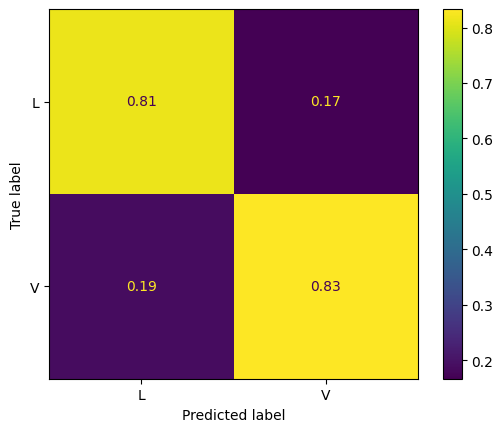

In [55]:
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(y_test, y_pred , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)

disp.plot()

Soccer game involves much uncertainties. Though some of the prediction is not 100% right, the testing result predict most of the games in the training set.


### Predicting the game

Here is the predicting W/L/D and probability of them of each game based on our very simple model:


In [56]:
y_prob = bestmodel.predict_proba(X_2)
y_result = bestmodel.predict(X_2)
print([np.round(y_prob,3),y_result])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Combining the game predicting result with the Time and Teams in one DataFrame:


In [ ]:
cols_result = ['Time','Home Team','Away Team','Predicted result','Home Win rate','Draw rate','Home Lose rate']
Result_df = pd.DataFrame([], columns=cols_result)
Result_df['Time'] = match.iloc[:48,1].values
Result_df['Home Team'] = match.iloc[:48,2].values
Result_df['Away Team'] = match.iloc[:48,3].values
Result_df['Predicted result'] = y_result
Result_df['Home Win rate'] = np.round(y_prob[:,2],3)
Result_df['Draw rate'] = np.round(y_prob[:,0],3)
Result_df['Home Lose rate'] = np.round(y_prob[:,1],3)
Result_df
#content_result = np.concatenate(match.iloc[:,1].values,match.iloc[:,2].values,match.iloc[:,3].values,y_result,np.round(y_prob[:,2],3),np.round(y_prob[:,0],3),np.round(y_prob[:,1],3))
#content_result.transpose()

#Result_df

Showing the predicting probability in a diagram:


In [ ]:
A = Result_df.loc[Result_df['Home Team'] == 'Japan']
A = A.loc[A['Away Team'] == 'Spain']

data = {'Japan Win':A['Home Win rate'].values[0], 'Draw':A['Draw rate'].values[0], 'Spain Win':A['Home Lose rate'].values[0]}
number = list(data.keys())
values = list(data.values())
c = ['blue', 'yellow', 'red']

plt.bar(number, values, color = c, width = 0.4)
plt.title("Result probability of Japan VS Spain", y=1.012)
plt.ylabel("probability", labelpad=3);

plt.show()

### Analyze the model

The neural network models is just like a black box. **But can we get some information from the black-box? Like what position is important for a good soccer team?**

**LIME** and **SHAP** could help with the interpretability.

They are surrogate models. They both **tweak** the input slightly (like we do in sensitivity tests) and **test the changes in prediction**. From the influence, we know how each features is related to the labels.

Let's see how the two models work:

#### LIME


### AIXÒ NO M'HA FUNCIONAT MAI

We first name down the 24 feature's meaning (e.g. M4_1 means the forth midfield in team1)


In [ ]:
Label_name = ['Team1_Age','Team2_Age','GK_1','RB_1','CB1_1','CB2_1','LB_1','M1_1','M2_1','M3_1','M4_1','F1_1','F2_1','GK_2','RB_2','CB1_2','CB2_2','LB_2','M1_2','M2_2','M3_2','M4_2','F1_2','F2_2',
                'Def1', 'Mid1', 'Att1', 'Def2', 'Mid2', 'Att2']  

We use a popular game  Spain VS Germany as an example of Lime analysis


In [ ]:
# Setting the lime explainer
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=Label_name,
    class_names=['D','L','W'],
    mode='classification'
)

# to Check the game 28 Spain VS Germany
Exam_1 = X_2[27]

# Continue to set the lime explainer
lime_exp = lime_explainer.explain_instance(
    data_row=Exam_1,
    predict_fn=bestmodel.predict_proba,
    num_features=30
)

#plot the result
lime_exp.show_in_notebook(show_table=True)

Using the Lime model. We get the result above. The orange means the feature is positively correlated to Germany winning the game; blue is positively correlated to Germany lose the game.
We could found some interesting hints of the game.

___(1) The game highly possible will be draw___

___(2) The center line largely influcence the game, especially the midfield.___

___(3) It never says if a team has best player in every position has larger opportunity to win.___


#### SHAP


In [ ]:
# Setting the SHAP explainer
explainer = shap.KernelExplainer(bestmodel.predict_proba, X_1)

#Calculate SHAP value
shap_values = explainer.shap_values(X_2)

Here, in SHAP, we could display each parameter's influence on the final result by using ___summary plot___ in SHAP. Blue is team 1 wins, pink is draw, brown is team 2 wins:


In [ ]:
#Plot the features influence in general for all the training the game
shap.summary_plot(shap_values, X_2,
                  feature_names=Label_name,
                  class_names=['D','L','W'],
                  max_display=30)

Here, from the diagram:

___(1) Ages don't matter that much!___

___(2) Every position all contributed to a game, but the importance is not the same. The most noticable position striker (Foward#2) is only icing on the cake, a good shooter always need a good team.___

___(3) Good defense at least could help team to get a draw result.___


We can see each positions' player's potential influence to each game in a the World Cup by using ___force_plot___ in SHAP. 

We also see which game could highly possible be a draw game, and could tell which player make the W/L happen. 

_Red is draw, Blue is not draw here._


In [ ]:
shap.initjs() #initial jacascript in cell
shap.force_plot(explainer.expected_value[0], shap_values[0], X_1)#, feature_names=Label_name)

----
